**Anna Smith**

**GitHub username: acs-233**

**Imperial College London - MSc EDSML - IRP**
# **XGBoost model to predict $\text{BECO}_2\text{N}$ data**

In [28]:
from sklearn.model_selection import train_test_split

In [2]:
from bayareaco2.models.data import load_Xy
from bayareaco2.models.data import fit_scaler, scale_features
from bayareaco2.models.data import feature_selection

In [3]:
from bayareaco2.models.xgboost import XGBoost_Model

/Users/annasmith/anaconda3/envs/irp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading in Data

In [4]:
# Loading the data
X, y, node_id = load_Xy(return_node_id=True)

Dropping 18 features with all zero data
Number of observations: 17389
Number of features: 105


In [5]:
# Standardizing the data
scaler = fit_scaler(X)
X_scaled = scale_features(scaler, X)

In [6]:
# Splitting data: training and test set
full_X_train, X_test, full_y_train, y_test, full_node_id_train, node_id_test = train_test_split(X_scaled, y, node_id, test_size=0.2, random_state=42)

In [7]:
# Splitting the data: training and validation set
X_train, X_val, y_train, y_val, node_id_train, node_id_val= train_test_split(full_X_train, full_y_train, full_node_id_train, test_size=0.2, random_state=42)

In [8]:
# Printing the length of the datasets
print(f"Full training set length: {len(full_X_train)}")
print(f"Full test set length: {len(X_test)}")
print(f"Training set length: {len(X_train)}")
print(f"Validation set length: {len(X_val)}")

Full training set length: 13911
Full test set length: 3478
Training set length: 11128
Validation set length: 2783


## Feature Selection

In [9]:
# Feature selection
selected_features = feature_selection(X_train, y_train, return_spearman_vif=False)

32 features selected with Spearman's correlation coefficient ≥ 0.03
11 features selected with VIF < 3: 

11 features selected: 

temp
pressure
rh
Trees_area_50m
total_road_length_1000m
total_road_length_200m
Built_Area_area_2000m
total_AADT_3000m
Flooded_Vegetation_area_1000m
Industrial_area_5000m
avg_ndvi_50m


In [10]:
# Filtering dataframes with selected features
X_scaled = X_scaled[selected_features]
X_train = X_train[selected_features]
X_val = X_val[selected_features]
full_X_train = full_X_train[selected_features]
X_test = X_test[selected_features]

## Training XGBoost Model

In [12]:
# Defining best parameters (from XGBoost_training.ipynb)
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

In [13]:
# Instantiating the model
model = XGBoost_Model(**best_params)

In [14]:
# Fitting the model
model.fit(X_train, y_train)

R²: 0.60
Mean Squared Error (MSE): 145.02
Root Mean Squared Error (RMSE): 12.04
Mean Absolute Error (MAE): 8.82


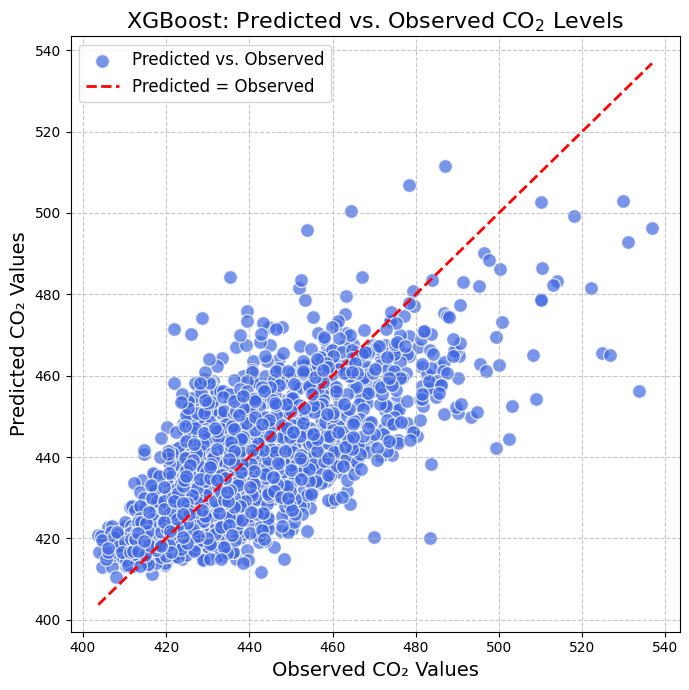

In [15]:
# Evaluating the model using validation set
train_xgb_results = model.evaluate(X_val, y_val)

In [16]:
# Cross-validating the model
cv_train_xgb_results = model.cross_validate(full_X_train, full_y_train)

10-fold CV R²: 0.58
10-fold CV Mean Squared Error (MSE): 159.09
10-fold CV Root Mean Squared Error (RMSE): 12.60
10-fold CV Mean Absolute Error (MAE): 9.09


## Final XGBoost

In [17]:
# Instantiating the final model
final_model = XGBoost_Model(**best_params)

In [18]:
# Fitting the final model using all training data
final_model.fit(full_X_train, full_y_train)

R²: 0.58
Mean Squared Error (MSE): 157.66
Root Mean Squared Error (RMSE): 12.56
Mean Absolute Error (MAE): 9.14


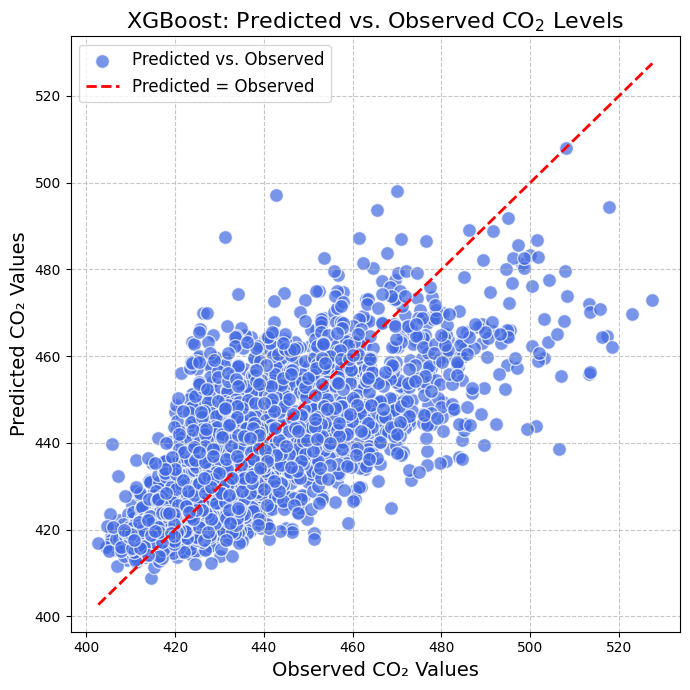

In [19]:
# Evaluating the final model using reserved test data
final_xgb_results = final_model.evaluate(X_test, y_test)

In [20]:
# Cross-validating the final model
final_cv_xgb_results = final_model.cross_validate(X_scaled, y)

10-fold CV R²: 0.58
10-fold CV Mean Squared Error (MSE): 157.26
10-fold CV Root Mean Squared Error (RMSE): 12.54
10-fold CV Mean Absolute Error (MAE): 9.05


In [30]:
import numpy as np

In [33]:
sorted_indices

array([ 8,  5,  9, 10,  6,  4,  7,  2,  3,  0,  1])

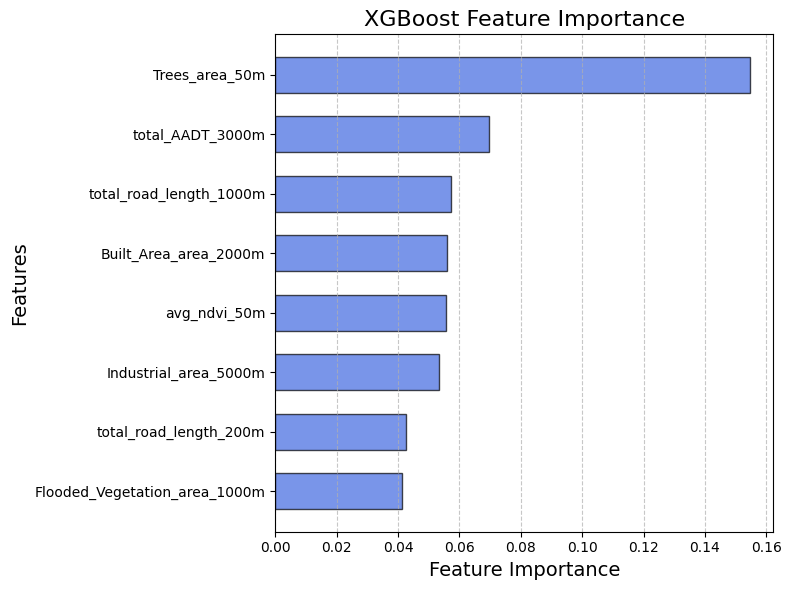

In [35]:
feature_importances = final_model.model.feature_importances_
sorted_indices = np.argsort(feature_importances)

delete_index = [7, 9, 10]

sorted_indices = np.delete(sorted_indices, delete_index)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.barh(
    X_train.columns[sorted_indices],
    feature_importances[sorted_indices],
    color="royalblue",
    alpha=0.7,
    edgecolor="k",
    height=0.6,
)

# Add labels and title
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("XGBoost Feature Importance", fontsize=16)

# Add horizontal gridlines
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

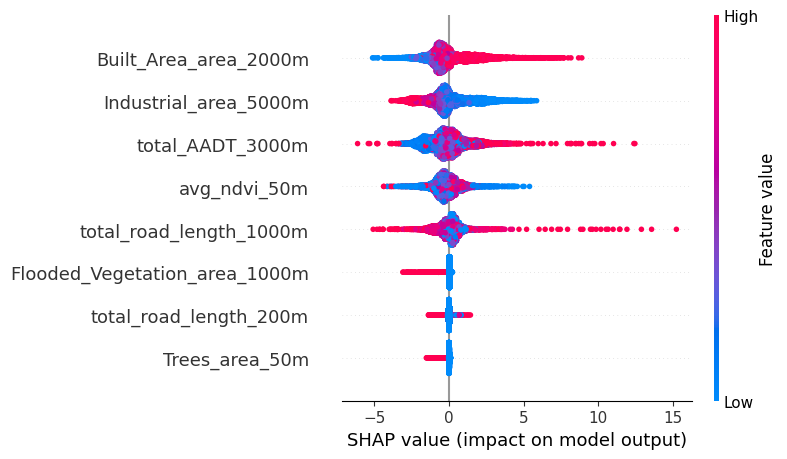

In [38]:
import shap

# Initialize the SHAP explainer and calculate the SHAP values
explainer = shap.Explainer(final_model.model)
shap_values = explainer(X_train)

# Identify the top 3 features to exclude
top_features = list(shap_values.feature_names[:3])

# Filter out the top 3 features from both the shap_values and X_train
filtered_features = [feature for feature in X_train.columns if feature not in top_features]
filtered_shap_values = shap_values[:, filtered_features]

# Create the summary plot without the top 3 features
shap.summary_plot(filtered_shap_values, X_train[filtered_features])


## Exploring Feature Importances

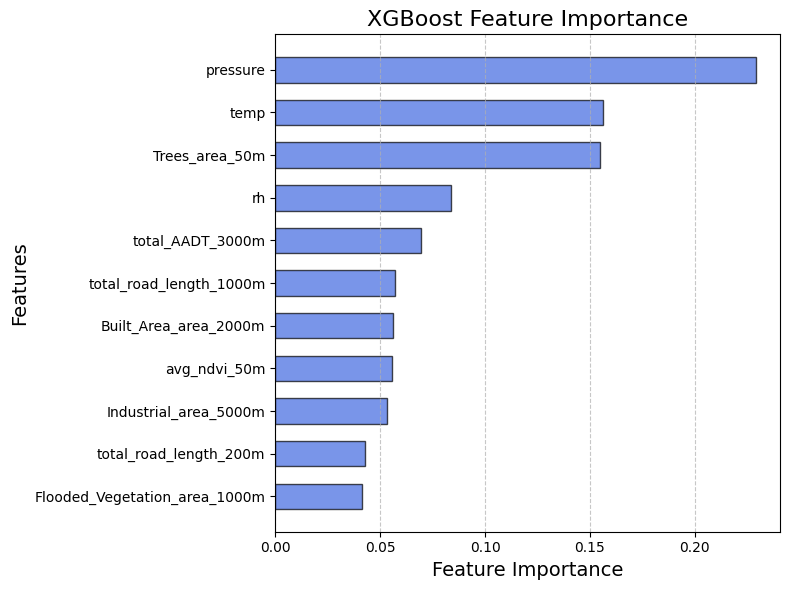

In [21]:
# Plotting the feature importances using gain metric
final_model.plot_importances(full_X_train)

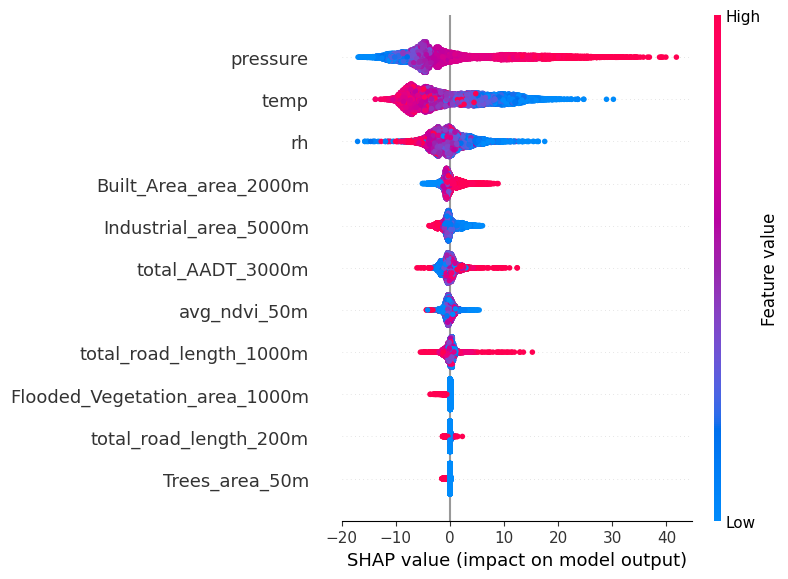

In [22]:
# Plotting the SHAP values
final_model.plot_shap(full_X_train)

## Evaluating Central Test Nodes

Overall Performance Metrics:
R²: 0.42
Mean Squared Error (MSE): 305.67
Root Mean Squared Error (RMSE): 17.48
Mean Absolute Error (MAE): 12.90 



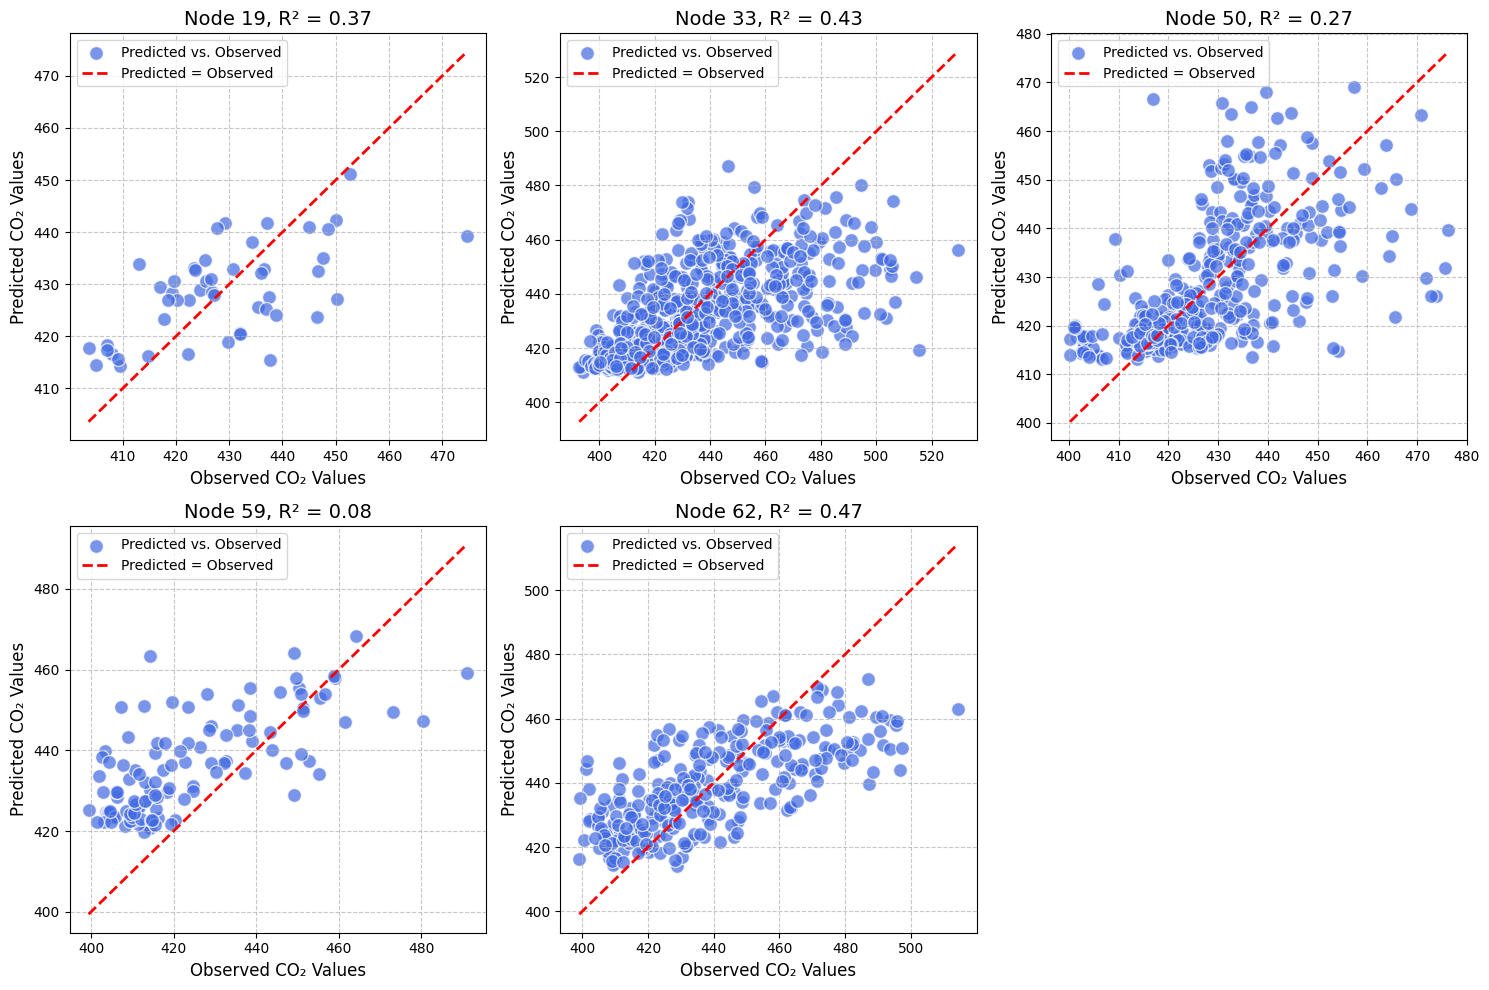

In [23]:
# Evaluating the model on central test nodes
central_node_metrics, central_overall_metrics = final_model.evaluate_test_nodes(selected_features, scaler, X.columns, nodes='central')

## Evaluating Fringe Test Nodes

Overall Performance Metrics:
R²: -0.88
Mean Squared Error (MSE): 451.14
Root Mean Squared Error (RMSE): 21.24
Mean Absolute Error (MAE): 18.11 



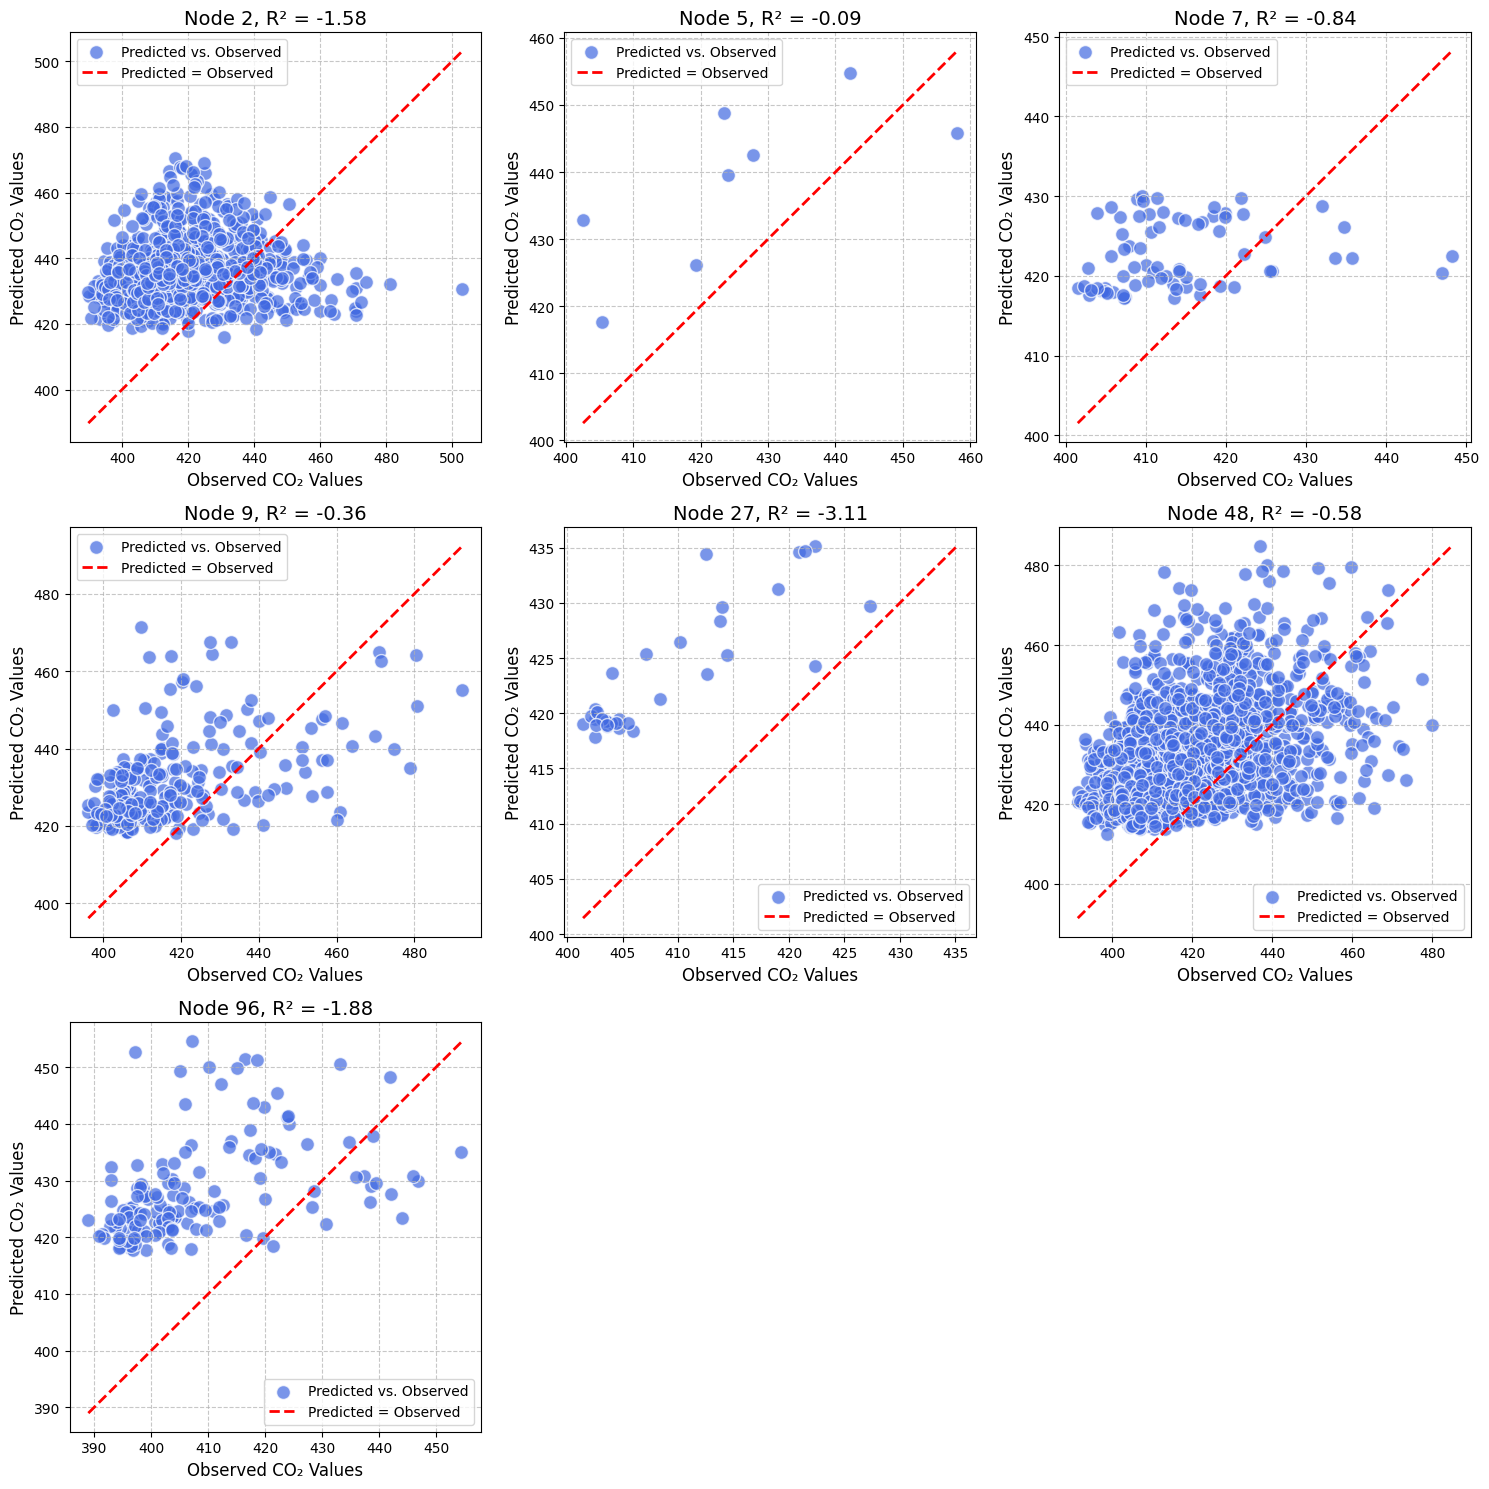

In [24]:
# Evaluating the model on fringe test nodes
fringe_node_metrics, fringe_overall_metrics = final_model.evaluate_test_nodes(selected_features, scaler, X.columns, nodes='fringe')

## Results Map

In [25]:
# Creating results map and individual node performance dataframe
node_eval_df, node_map = final_model.make_node_map(full_X_train, selected_features, scaler, X.columns)

In [26]:
# Viewing the node map
node_map

In [27]:
# Viewing the node evaluation dataframe
node_eval_df

,node_id,n,R²,MSE,RMSE,MAE
0,2,1185,-1.58,571.21,23.90,21.04
1,3,299,0.12,238.99,15.46,12.26
2,4,110,0.07,319.77,17.88,12.75
3,5,8,-0.09,315.28,17.76,16.23
4,7,73,-0.84,172.42,13.13,11.60
...,...,...,...,...,...,...
60,96,151,-1.88,566.53,23.80,21.99
61,125,43,0.30,163.77,12.80,10.07
62,280,114,0.50,121.65,11.03,7.31
63,281,181,0.65,108.60,10.42,7.54
